In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from generate_solar_data import plot_points
from visualise_solar_and_wind_data import *
import os
import re 
import folium
import webbrowser
import matplotlib as mpl
mpl.rcParams.update({'font.size': 19})


In [69]:
## Looking at data over the course of the year:
def plot_yearly_data():
    fig, ax = plt.subplots(nrows=3, ncols = 6, figsize = (28,12))
    axs = ax.ravel()

    for i in range(len(axs)): 
        wind_df = parse_data("./winddata/"+os.listdir("./winddata")[i])
        solar_df = parse_data("./pvdata/"+os.listdir("./pvdata")[i])

        wind_df.rolling(720).mean().plot(ax =axs[i], label = 'Wind Data')
        solar_df.rolling(720).mean().plot(ax =axs[i], label = 'Solar Data')
        
        axs[i].legend(['Wind Data','Solar Data'])
        axs[i].set_xlabel("")
        if i != 0:
            axs[i].legend().set_visible(False)
        # axs[i].axes.xaxis.set_visible(False)
        axs[i].set_title("Location = {}, {}".format(get_coordinates("./winddata")[i][0], get_coordinates("./winddata")[i][1]))
    fig.tight_layout()

We want to confirm whether there is significant variation in the wind profiles throughout the country

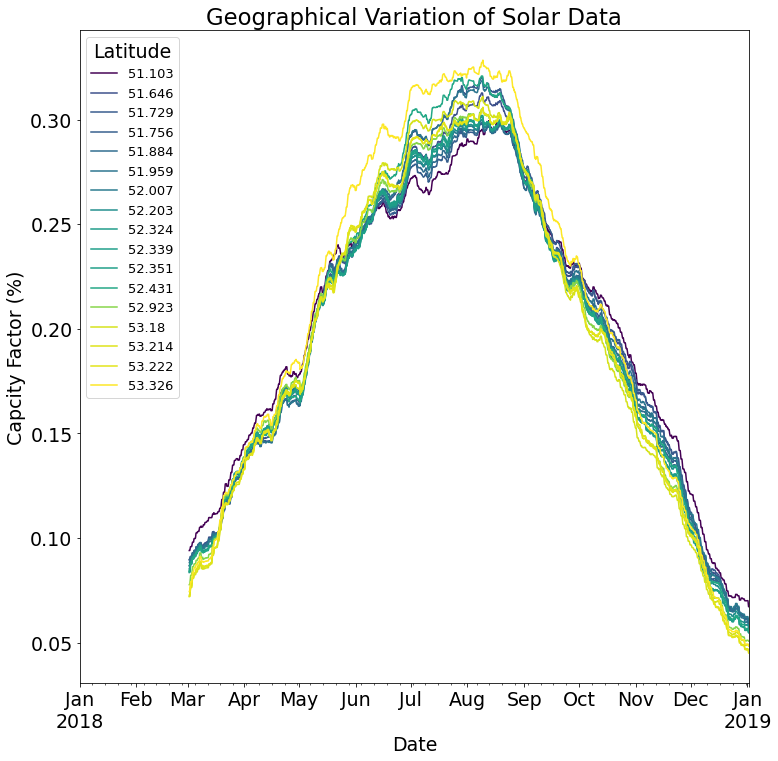

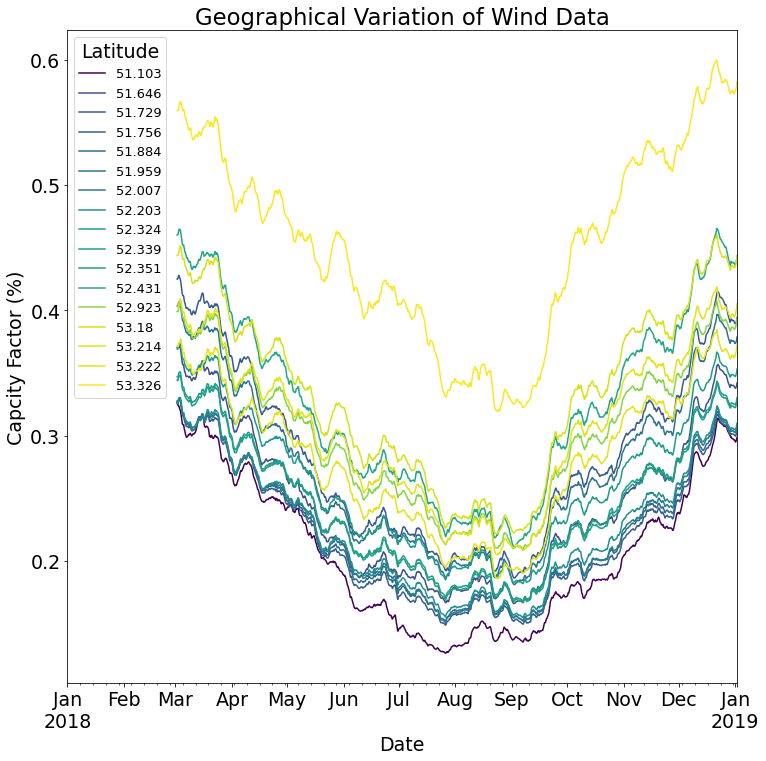

In [80]:
def geographic_variation_plot(directory_name, title, save_name):
    coordinates = get_coordinates(directory_name)
    norm = mpl.colors.Normalize(vmin=coordinates[0][0], vmax=coordinates[-1][0])
    colors = plt.cm.viridis([norm(coord[0]) for coord in coordinates])
    # colors
    fig, ax = plt.subplots(figsize = (12,12))
    for i in range(len(os.listdir(directory_name))):
        df = parse_data(directory_name+os.listdir(directory_name)[i])
        df.rolling(1440).mean().plot(ax =ax, c =colors[i])
        ax.legend([coord[0] for coord in coordinates], prop={'size': 13}, title = 'Latitude')
        ax.set_xlabel('Date')
        ax.set_ylabel('Capcity Factor (%)')
    plt.title(title)
    plt.savefig(save_name, dpi = 300)

geographic_variation_plot("./pvdata/", "Geographical Variation of Solar Data", "./Plots/PVGeographicalVariation.png")
geographic_variation_plot("./winddata/", "Geographical Variation of Wind Data", "./Plots/WindGeographicalVariation.png")

Next I want to look at monthly variation!

C:\Users\joshb\AppData\Local\Temp/ipykernel_20020/1587939814.py:10: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  df['woy'] = df.index.weekofyear
C:\Users\joshb\AppData\Local\Temp/ipykernel_20020/1587939814.py:10: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  df['woy'] = df.index.weekofyear


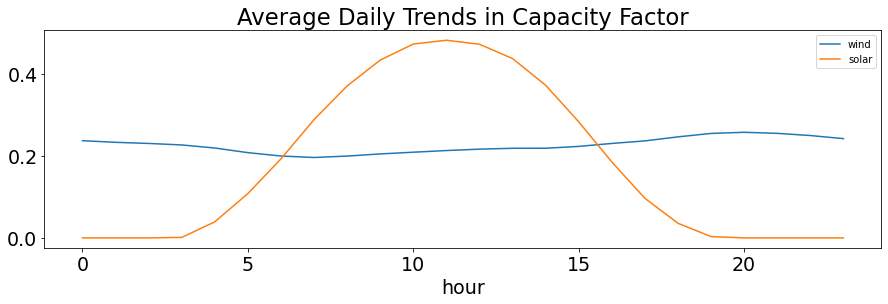

In [118]:
## Looking at daily patterns of data
def daily_trend_plot(df, ax):
    """ Take on a timeseries dataframe and plot the average daily trend """
    df['dow'] = df.index.dayofweek
    df['doy'] = df.index.dayofyear
    df['year'] = df.index.year
    df['month'] = df.index.month
    df['quarter'] = df.index.quarter
    df['hour'] = df.index.hour
    df['woy'] = df.index.weekofyear
    df['dom'] = df.index.day # Day of Month
    dowdict = {0:'Monday',1:'Tuesday',2:'Wednesday',3:'Thursday',4:'Friday',5:'Saturday',6:'Sunday'}
    df['weekday'] = df['dow'].map(dowdict)
    df.pivot_table(index='hour', 
                #    columns='weekday', 
                   values='electricity',
                   aggfunc='mean').plot(ax=ax,
                   title='Average Daily Trends in Capacity Factor')
    # return df
fig, ax = plt.subplots(figsize=(15,4))

daily_trend_plot(parse_data("./winddata/"+os.listdir("./winddata")[0]), ax =ax)
daily_trend_plot(parse_data("./pvdata/"+os.listdir("./pvdata")[0]), ax =ax)
ax.legend(['wind','solar'],prop = {'size':10})
plt.savefig("./Plots/AvDailyTrends.png", dpi=300)

In [ ]:
plot_points(coordinates[0:2])
